In [1]:
from copy import deepcopy
import tqdm

import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import torch

from adaptive_mcmc.distributions.distribution import GaussianMixture
from adaptive_mcmc.samplers import base_sampler, mala, fishermala, hmc
from adaptive_mcmc.samplers.stopping_rule import TVStop, NoStop
from adaptive_mcmc.tools.benchmark import BenchmarkUtils, Benchmark

2025-01-02 23:59:23.139509: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735851563.148087   20432 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735851563.150700   20432 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [32]:
seed = 123
torch.manual_seed(seed)

device = "cpu"

hparams = {
    "mala": mala.MALAParams(
        sigma=1.0,
        sigma_lr=0.015,
        target_acceptance=0.574,
        device=device,
    ),
    "fisher_mala": fishermala.FisherMALAParams(dampening=10.),
    "hmc_vanilla": hmc.HMCParams(lf_step_count=10, lf_step_size=0.5)
}

In [33]:
chain_count = 15
dimensions = [25] #, 5, 10, 100, 10]
gaussian_count = 10
distance_to_mass_points = 1.
tv_threshold = 0.05
sample_count = 1000
sample_iter_limit = 2000
burn_in_iter_count = 1000
probe_period = 2500
cube = 1.
tail_count_cap = 1000

# stopping_rule = TVStop(threshold=tv_threshold, density_probe_count=1000,
#                        projection_count=25, tail_count_cap=tail_count_cap)

stopping_rule = NoStop(density_probe_count=500,
                       projection_count=25, tail_count_cap=tail_count_cap)

algs = {
    # "fisher_mala": fishermala.FisherMALAVanilla(
    #     pipeline=None,
    #     name="FisherMALA",
    #     sigma_burn_in_params=hparams["fisher_mala"].copy(),
    #     sigma_burn_in_iter_count=500,
    #     prec_burn_in_params=hparams["fisher_mala"].copy(),
    #     prec_burn_in_iter_count=burn_in_iter_count - 500,
    #     sample_iter_count=sample_iter_limit,
    #     stopping_rule=stopping_rule,
    #     probe_period=probe_period
    # ),
    "mala": mala.MALAVanilla(
        pipeline=None,
        name="MALA",
        sigma_burn_in_params=hparams["mala"].copy(),
        sigma_burn_in_iter_count=burn_in_iter_count,
        sample_iter_count=sample_iter_limit,
        stopping_rule=stopping_rule,
        probe_period=probe_period,
    ),
    "hmc_vanilla": hmc.HMCVanilla(
        pipeline=None,
        name="HMCVanilla",
        params=hparams["hmc_vanilla"].copy(),
        sample_iter_count=sample_iter_limit,
        burn_in_iter_count=burn_in_iter_count,
        stopping_rule=stopping_rule,
        probe_period=probe_period,
    )
}

In [34]:
hist_data = {}
runtime = {
    dimension: dict()
    for dimension in dimensions
}
pure_runtime = deepcopy(runtime)

for dimension in tqdm.notebook.tqdm(dimensions):
    print("Processing dimension", dimension)
    hist_data[dimension] = {}

    true_means = torch.rand((gaussian_count, dimension)) * cube - cube / 2
    true_covs = torch.rand((gaussian_count, dimension, dimension))
    true_covs = (
        true_covs @ true_covs.permute(0, 2, 1) +
        torch.eye(dimension).repeat(gaussian_count, 1, 1)
    )

    gm = GaussianMixture(
        true_means,
        true_covs,
        torch.full((gaussian_count,), 1/gaussian_count, dtype=torch.float64)
    )

    starting_points = BenchmarkUtils.generate_starting_points(
        chain_count, dimension,
        true_means,
        distance_to_mass_points,
    )
    true_samples = gm.sample(sample_count)

    params = base_sampler.Params(
        target_dist=gm,
        starting_point=starting_points,
        proposal_dist=torch.distributions.MultivariateNormal(
            torch.zeros(dimension, device=device),
            torch.eye(dimension, device=device),
        ),
    )

    for alg in algs:
        print("-" * 80)
        base_meta_adj = hparams[alg].copy_update(params)
        if hasattr(base_meta_adj, "sigma"):
            base_meta_adj.sigma /= dimension

        algs[alg].load_params(base_meta_adj)
        algs[alg].load_true_samples(true_samples)
        algs[alg].run()

        hist_data[dimension][alg] = [
            algs[alg].pipeline.sample_blocks[-1].iteration.cache,
            algs[alg].pipeline.sample_blocks[-1].stop_data_hist
        ]
        runtime[dimension][alg] = algs[alg].pipeline.runtime
        pure_runtime[dimension][alg] = algs[alg].pipeline.pure_runtime
    print()

  0%|          | 0/1 [00:00<?, ?it/s]

Processing dimension 25
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

processing block: 2


  0%|          | 0/2000 [00:00<?, ?it/s]

Runtime: 2.35s
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 2
processing block: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

processing block: 2


  0%|          | 0/2000 [00:00<?, ?it/s]

Runtime: 16.90s



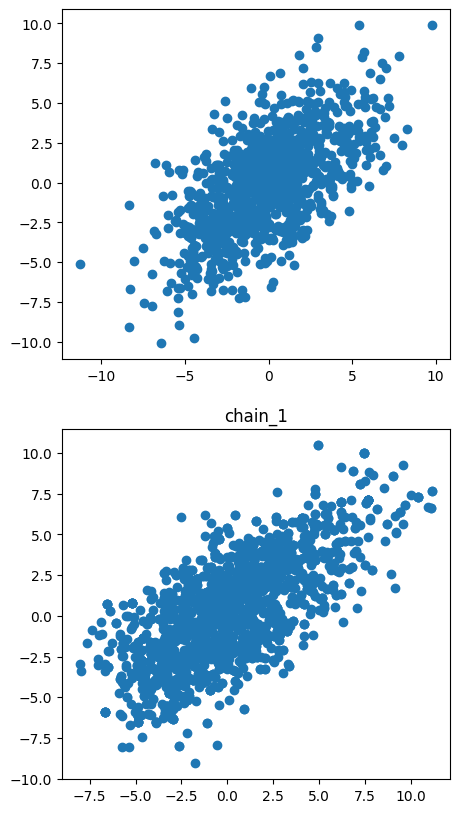

In [26]:
BenchmarkUtils.create_plot(
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [0], :],
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

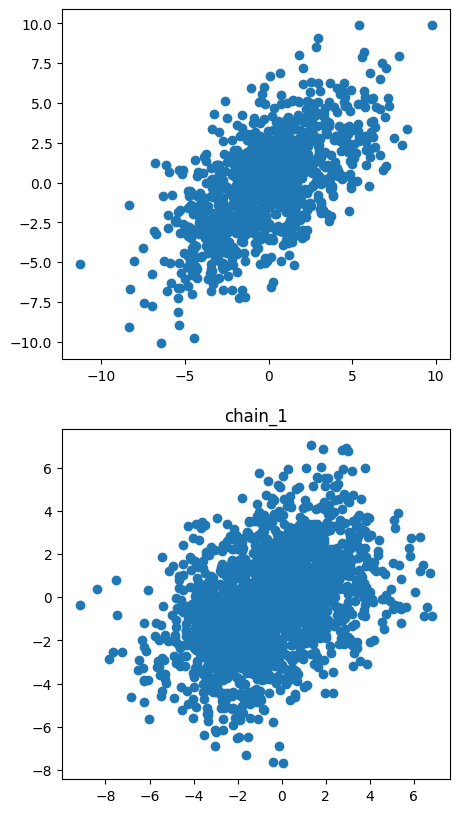

In [27]:
BenchmarkUtils.create_plot(
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [0], :],
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [8]:
tv_threshold = 0.05

In [28]:
pure_runtime

{25: {'mala': 2.354003485990688, 'hmc_vanilla': 16.98014341320959}}

In [10]:
runtime

{2: {'mala': 1.764094929996645, 'hmc_vanilla': 2.1143578180053737}}

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

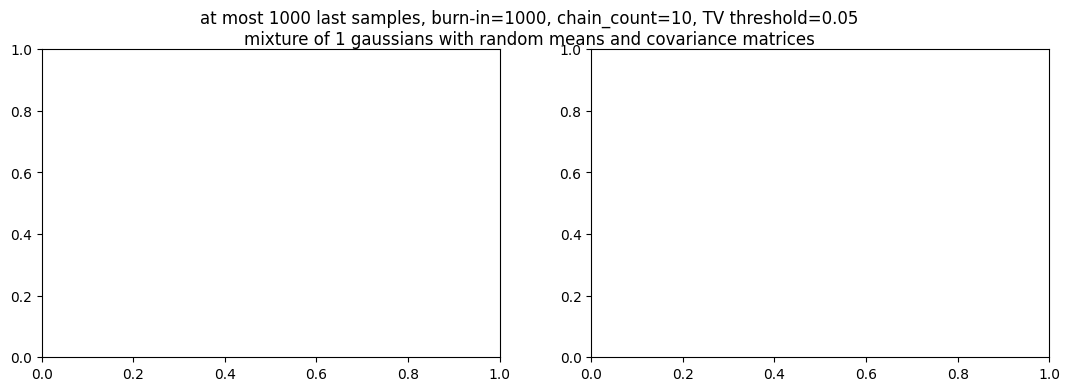

In [11]:
fig, axes = plt.subplots(
    nrows=len(dimensions),
    ncols=2,
    figsize=(13, 4 * len(dimensions),)
)
fig.suptitle(
    f"at most {tail_count_cap} last samples, burn-in={burn_in_iter_count}, "
    f"chain_count={chain_count}, "
    f"TV threshold={tv_threshold}\n" +
    f"mixture of {gaussian_count} gaussians with "
    "random means and covariance matrices"
)

for dim_ind in range(len(dimensions)):
    for alg_ind, alg in enumerate(algs.keys()):

        ticks_count = len(hist_data[dimensions[dim_ind]][alg][1])
        xticks = probe_period * jnp.arange(1, ticks_count + 1)

        axes[dim_ind, alg_ind].plot(
            xticks,
            [
                entry["tv_mean"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            label="TV mean"
        )
        axes[dim_ind, alg_ind].fill_between(
            xticks,
            [
                entry["tv_mean"] - 2 * entry["tv_std"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            [
                entry["tv_mean"] + 2 * entry["tv_std"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            alpha=0.1,
            label="95% CI"
        )
        axes[dim_ind, alg_ind].axhline(tv_threshold, color="r", linestyle="dashed")
        axes[dim_ind, alg_ind].set_title(f"{alg}, dim={dimensions[dim_ind]}")
        if dim_ind + 1 == len(dimensions):
            axes[dim_ind, alg_ind].set_xlabel("iteration")
        axes[dim_ind, alg_ind].set_ylabel("TV")
        axes[dim_ind, alg_ind].legend()

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [30]:
BenchmarkUtils.compute_metrics(
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

{'ess': np.float32(0.00769363),
 'tv_mean': Array(0.12876661, dtype=float32),
 'tv_conf_sigma': Array(0.07397138, dtype=float32),
 'wasserstein': 123.08959823751954}

In [35]:
BenchmarkUtils.compute_metrics(
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

{'ess': np.float32(0.056352954),
 'tv_mean': Array(0.04426257, dtype=float32),
 'tv_conf_sigma': Array(0.01351818, dtype=float32),
 'wasserstein': 83.10511259780623}

### Reference

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)